In [1]:
from slim_gsgp_lib_np.main_slim import slim
from slim_gsgp_lib_np.utils.utils import train_test_split
from slim_gsgp_lib_np.utils.callbacks import *
from slim_gsgp_lib_np.evaluators.fitness_functions import rmse
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import time
import os
from tqdm import tqdm
from functions.test_funcs import mape, nrmse, r_squared, mae, standardized_rmse
from matplotlib import pyplot as plt
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.mutators import *
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.simplifiers import *
from slim_gsgp_lib_np.datasets.data_loader import *
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from slim_gsgp_lib_np.selection.selection_algorithms import tournament_selection_min
from datasets_multislim.synthetic_datasets import * 

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

from slim_gsgp_lib_np.main_gp import gp
# from slim_gsgp_lib_np.algorithms.GP.representations.tree import Tree

# -------------------------- # 
from slim_gsgp_lib_np.utils.utils import check_slim_version
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.tree import Tree
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition import Condition
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.population import Population    
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.tree_utils import *
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.operators.mutators import *
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.operators.xo import *
from slim_gsgp_lib_np.config.multi_slim_config import SlimParameters, GPParameters
from slim_gsgp_lib_np.main_multi_slim import multi_slim 

In [ ]:
from slim_gsgp_lib_np.utils.callbacks import SLIM_GSGP_Callback
from collections import defaultdict
from itertools import chain
import itertools
import numpy as np
from scipy.optimize import linear_sum_assignment

class LogSpecialist(SLIM_GSGP_Callback):
    def __init__(self, masks, X_train, y_train):
        self.log = []
        self.count_specialists = []
        self.masks = masks 
        self.X_train = X_train
        self.y_train = y_train

    def on_generation_start(self, optimizer, generation):     
        if not generation % 10 == 0:
            return 

        mins = [1e10] * len(self.masks)
        best = [None] * len(self.masks)
        counts = [0] * len(self.masks)
        for ind in optimizer.population:
            for i, mask in enumerate(self.masks):
                preds = ind.predict(self.X_train[mask])
                fitness = rmse(self.y_train[mask], preds)
                if fitness < mins[i]:
                    mins[i] = fitness
                    best[i] = ind
                    counts[i] = 1
                elif fitness == mins[i]:
                    counts[i] += 1
        self.log.append(mins)
        self.count_specialists.append(counts)

    def plot_specialist_fitnesses(self):
        fig, ax = plt.subplots()
        ax.plot(self.log)
        ax.set_xlabel('Generation')
        ax.set_ylabel('RMSE')
        ax.set_title('Fitness of Specialists')
        ax.legend([f'Specialist {i+1}' for i in range(len(self.masks))])
        plt.show()

def get_specialist_masks(tree_node, X_data, current_mask=None):

    """
    Function used to get the masks for each specialist to be used for specialist tunning

    Write the rest of the documentation 

    """
    def recursion(tree_node, X_data, current_mask=None):
        if current_mask is None:
            current_mask = np.ones(X_data.shape[0], dtype=bool)
        
        if isinstance(tree_node, tuple):  # Condition node
            condition = tree_node[0]
            left_child = tree_node[1]
            right_child = tree_node[2]
            
            # Evaluate condition
            cond_results = condition.predict(X_data) > 0
            true_mask = current_mask & cond_results
            false_mask = current_mask & ~cond_results
            
            # Process both branches
            left_masks = recursion(left_child, X_data, true_mask)
            right_masks = recursion(right_child, X_data, false_mask)
            
            # Merge results while preserving all masks
            merged = defaultdict(list)
            for sp, masks in chain(left_masks.items(), right_masks.items()):
                merged[sp].extend(masks)
                
            return merged
            
        else:  # Specialist node (leaf)
            return {tree_node: [current_mask]}
    
    result = recursion(tree_node, X_data)
    merged = defaultdict(list)

    for ind, mask in result.items(): 
        merged[ind] = np.sum(mask, axis=0).astype(bool)

    return merged    

def calculate_specialist_rmse(ensemble_tree, X_train, y_train):
    """
    Calculates RMSE for each specialist on samples where their decision paths activate
    
    Parameters:
    ensemble_tree: The trained ensemble tree structure
    X_train (array-like): Training features
    y_train (array-like): True target values
    specialists (dict): Dictionary of specialist objects
    
    Returns:
    dict: Specialist IDs mapped to their path-specific RMSE scores
    """
    # Get all activation masks
    masks = get_specialist_masks(ensemble_tree.collection, X_train)
    specialists = ensemble_tree.SPECIALISTS
    
    # Calculate RMSE for each specialist
    rmse_scores = {}
    
    for sp_id, mask_list in masks.items():
        if sp_id not in specialists:
            continue
            
        # Combine all paths for this specialist
        combined_mask = mask_list
        n_samples = np.sum(combined_mask)
        
        if n_samples == 0:
            rmse_scores[sp_id] = (0, np.nan)
            continue
            
        # Get predictions for active samples
        X_active = X_train[combined_mask]
        y_true = y_train[combined_mask]
        y_pred = specialists[sp_id].predict(X_active)
        
        # Calculate RMSE
        error = y_true - y_pred
        rmse_value = np.sqrt(np.mean(error**2))
        rmse_scores[sp_id] = (n_samples, rmse_value)
    
    return rmse_scores

def normalized_hamming_distance(mask1, mask2):
    """
    Compute the normalized Hamming distance between two boolean masks.
    The masks must be 1D numpy arrays of the same length.
    """
    return np.sum(mask1 != mask2) / mask1.size

def compute_composite_mask_distance(ground_truth_masks, predicted_masks, lambda_penalty=0.5):
    """
    Compute a composite distance between two sets of masks.
    
    ground_truth_masks and predicted_masks are lists (or arrays) of boolean masks.
    The distance is computed as the average normalized Hamming distance for the optimal 
    matching (using the Hungarian algorithm) plus a penalty for the difference in the number 
    of masks.
    
    Parameters:
      ground_truth_masks: list of 1D numpy boolean arrays (ground truth)
      predicted_masks: list of 1D numpy boolean arrays (predicted from the model)
      lambda_penalty: penalty weight for each extra/missing mask.
      
    Returns:
      composite_distance: the computed composite distance.
    """
    n_gt = len(ground_truth_masks)
    n_pred = len(predicted_masks)
    
    # Create cost matrix for the pairwise distances
    cost_matrix = np.zeros((n_gt, n_pred))
    for i, gt_mask in enumerate(ground_truth_masks):
        for j, pred_mask in enumerate(predicted_masks):
            cost_matrix[i, j] = normalized_hamming_distance(gt_mask, pred_mask)
    
    # Solve the assignment problem for the best matching
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    total_cost = cost_matrix[row_ind, col_ind].sum()
    avg_cost = total_cost / len(row_ind)
    
    # Add penalty for unmatched masks (if the numbers differ)
    unmatched = abs(n_gt - n_pred)
    composite_distance = avg_cost + lambda_penalty * unmatched
        
    return composite_distance

def compute_split_distance(gt_masks, pred_masks, lambda_penalty=0.5):
    """
    Compute the minimum distance between a predicted binary split (2 masks)
    and a multi-case ground truth by considering all ways to merge the ground
    truth masks into 2 clusters.
    """
    if type(pred_masks) == defaultdict:
        pred_masks = [value for key, value in pred_masks.items()]
    k = len(gt_masks)
    best_distance = np.inf
    
    # Enumerate all non-empty, non-full subsets up to symmetry
    for r in range(1, (k // 2) + 1):
        for combo in itertools.combinations(range(k), r):
            other = tuple(set(range(k)) - set(combo))
            
            # Avoid duplicate partitions when k is even and r == k/2
            if k % 2 == 0 and r == k // 2 and combo > other:
                continue
            
            # Aggregate masks by OR-ing within each cluster
            agg1 = np.any([gt_masks[i] for i in combo], axis=0)
            agg2 = np.any([gt_masks[i] for i in other], axis=0)
            
            # Compute distance for this partition
            dist = compute_composite_mask_distance([agg1, agg2], pred_masks, lambda_penalty)
            best_distance = min(best_distance, dist)
    
    return best_distance

In [50]:
mask_test = [np.array([True, False, False, False, False, False, False, False]),
             np.array([False, True, True, True, False, False, False, False]),
             np.array([False, False, False, False, True, True, True, False]),
             np.array([False, False, False, False, False, False, False, True])
]

mask_proposed = [np.array([True, False, False, False, True, True, True, True]),
                np.array([False, True, True, True, False, False, False, False]),
]

print(compute_split_distance(mask_test, mask_proposed)) 

0.0


In [8]:
x2, y2, mask2 = load_synthetic2()

Class 1 has 318 samples, and class 2 has 182 samples


+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |    div (var)    |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      2.083      |      2.148      |      0.003      |        7        |      4.300      |        36       |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|       test      |        1        |      2.083      |      2.148      |      0.012      

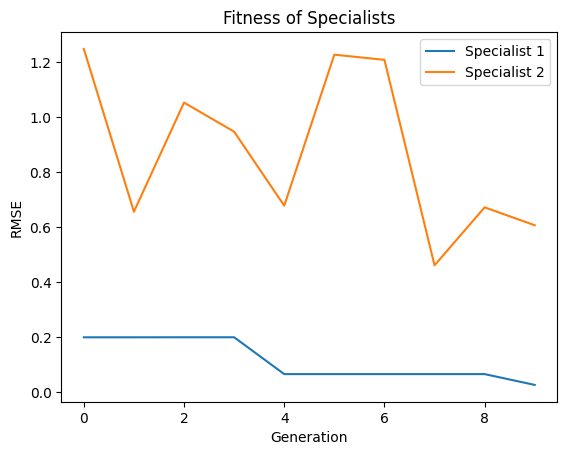

In [16]:
seed = 10

train_indices, test_indices = train_test_split(x2, y2, p_test=0.2, indices_only=True, seed=seed)
X_train = x2[train_indices]
y_train = y2[train_indices]
X_test = x2[test_indices]
y_test = y2[test_indices]
mask_train = [m[train_indices] for m in mask2]

log_specialist = LogSpecialist(mask_train, X_train, y_train)

params = GPParameters(pop_size=100, n_iter=100, max_depth=7, init_depth=3,
                      selector='dalex', p_xo=0.8, down_sampling=1, callbacks=[log_specialist])

ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='e_lexicase', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=10, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=3, depth_condition=6, down_sampling=1,
                                test_elite=True, timeout=200)

log_specialist.plot_specialist_fitnesses()

In [28]:
ensemble_tree.collection[1][1]

'S_26'

In [18]:
get_specialist_masks(ensemble_tree.collection, X_train)

defaultdict(list,
            {'S_26': array([False, False, False,  True, False, False, False, False, False,
                    False,  True,  True, False, False,  True, False,  True, False,
                    False, False,  True,  True, False, False, False,  True, False,
                    False,  True,  True,  True, False,  True, False,  True,  True,
                    False,  True, False,  True, False,  True,  True, False, False,
                    False,  True, False, False, False,  True, False,  True, False,
                    False, False, False, False, False, False, False, False,  True,
                    False,  True, False, False, False, False, False, False, False,
                     True, False, False, False,  True, False, False,  True, False,
                    False, False, False, False, False,  True, False, False, False,
                     True,  True, False, False,  True,  True, False, False, False,
                     True,  True, False, False, False,  True,

In [139]:
log_specialist = LogSpecialist(mask_train, X_train, y_train)

Class distribution:  114 127 118 141


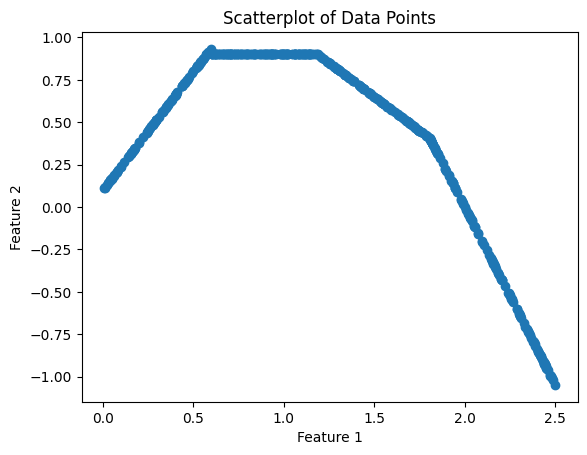

In [12]:
X, y, mask, mask_conditions = load_synthetic5()

# Scatterplot 
plt.scatter(X[:, 0], y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatterplot of Data Points')
plt.show()

In [19]:
seed = 0

train_indices, test_indices = train_test_split(X, y, p_test=0.2, indices_only=True, seed=seed)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]
mask_train = [m[train_indices] for m in mask]


params = GPParameters(pop_size=100, n_iter=100, max_depth=7, init_depth=3,
                      selector='dalex', p_xo=0.8, down_sampling=1, # callbacks=[log_specialist]
                      )

ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='dalex', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=100, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                test_elite=True, timeout=200)


+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |    div (var)    |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.562      |      0.547      |      0.005      |        3        |      4.220      |       145       |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|       test      |        1        |      0.554      |      0.482      |      0.007      

In [60]:
def compute_split_distance(gt_masks, pred_masks, lambda_penalty=0.5):
    """
    Compute the minimum distance between a predicted binary split (2 masks)
    and a multi-case ground truth by considering all ways to merge the ground
    truth masks into 2 clusters.
    """
    if type(pred_masks) != defaultdict:
        print('Warning: pred_masks is not a defaultdict')
        return None
    
    pred_masks = [value for key, value in pred_masks.items()]

    k = len(gt_masks)
    best_distance = np.inf
    
    # Enumerate all non-empty, non-full subsets up to symmetry
    for r in range(1, (k // 2) + 1):
        for combo in itertools.combinations(range(k), r):
            other = tuple(set(range(k)) - set(combo))
            
            # Avoid duplicate partitions when k is even and r == k/2
            if k % 2 == 0 and r == k // 2 and combo > other:
                continue
            
            # Aggregate masks by OR-ing within each cluster
            agg1 = np.any([gt_masks[i] for i in combo], axis=0)
            agg2 = np.any([gt_masks[i] for i in other], axis=0)
            
            # Compute distance for this partition
            dist = compute_composite_mask_distance([agg1, agg2], pred_masks, lambda_penalty)
            best_distance = min(best_distance, dist)
    
    return best_distance

In [61]:
masks_specialist = get_specialist_masks(ensemble_tree.collection, X_train)
print(compute_composite_mask_distance(masks_specialist.values(), mask_train, lambda_penalty=1))
print(compute_split_distance(mask_train, masks_specialist, lambda_penalty=1))

2.30125
0.0675


In [10]:
seed = 10

X, y = datasets[10]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.25)

params = GPParameters(pop_size=100, n_iter=1000, max_depth=7, init_depth=3,
                      selector='dalex', p_xo=0.8, down_sampling=1)

ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='e_lexicase', population=spec_pop,
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=2000, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=5, depth_condition=6, down_sampling=0.25,
                                test_elite=True, timeout=200)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |   total_nodes   |  average_depth  |       div       |       mut       |        xo       |      lex_r      |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      3.197      |      3.172      |      0.017      |        1        |        51       |      2.160      |       2829      |     N/A (0)     |     N/A (0)     |      0.000      |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |    div (var)    |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |     117.863     |     119.162     |      0.003      |        3        |      4.300      |        80       |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|       test      |        1        |     117.295     |     118.595     |      0.010      

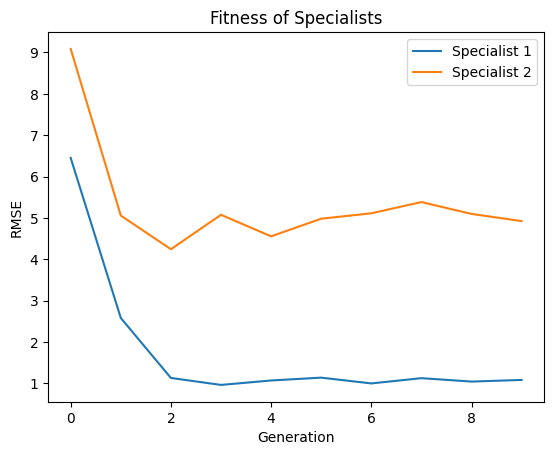

In [ ]:
seed = 10

x7, y7, mask7 = load_synthetic7(n=800, seed=0, noise=0)
train_indices, test_indices = train_test_split(x7, y7, p_test=0.2, indices_only=True, seed=seed)
X_train = x7[train_indices]
y_train = y7[train_indices]
X_test = x7[test_indices]
y_test = y7[test_indices]
mask_train = [m[train_indices] for m in mask7]

log_specialist = LogSpecialist(mask_train, X_train, y_train)

params = GPParameters(pop_size=100, n_iter=100, max_depth=7, init_depth=3,
                      selector='dalex', p_xo=0.8, down_sampling=1, callbacks=[log_specialist])

ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                gp_version='gp', params_gp=params, selector='dalex', 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=500, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=6, down_sampling=1,
                                test_elite=True, timeout=200)

log_specialist.plot_specialist_fitnesses()

In [154]:
masks_specialist = get_specialist_masks(ensemble_tree.collection, X_train)
print(compute_composite_mask_distance(masks_specialist.values(), mask_train, lambda_penalty=1))

0.0


GP RUN

In [ ]:
X, y = datasets[0]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)
seed = 10

elite, gp_pop = gp(X_train=X_train, y_train=y_train, full_return=True, test_elite=False, dataset_name='',
                       selector='tournament', n_iter=100, pop_size=100, 
                       max_depth=4, init_depth=3, p_xo=0.8, down_sampling=0.8, seed=seed, verbose=0,
                       )

In [2]:
X, y = datasets[2]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)
# X_train = MinMaxScaler().fit_transform(X_train)
# X_test = MinMaxScaler().fit_transform(X_test)
# y_train = MinMaxScaler().fit_transform(y_train.reshape(-1, 1)).ravel()
# y_test = MinMaxScaler().fit_transform(y_test.reshape(-1, 1)).ravel()

# X = np.random.rand(20, 2)
# y = np.random.rand(20)
# X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)

seed = 2

# agelog = LogAge()
# divlog = LogDiversity()
# early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train,
                    dataset_name='test', test_elite=False, slim_version='SLIM*ABS', # initializer='simple',
                    max_depth=15, init_depth=5, pop_size=100, n_iter=1000, seed=seed, verbose=1,
                    p_inflate=0.3, p_struct=0.3, n_cases=100,
                    prob_const=0.2, n_elites=1, selector='dalex', 
                    decay_rate=0.2, p_xo=0, p_struct_xo=0, prob_terminal=0.7,
                    # callbacks=[agelog, divlog, early_stop], 
                    mode='exp', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

for ind in population.population:
    ind.version = example_tree.version
    ind.train_semantics = ind.predict(X_train)
    ind.test_semantics = ind.predict(X_test)

FUNCTIONS = example_tree.collection[0].FUNCTIONS
TERMINALS = example_tree.collection[0].TERMINALS
CONSTANTS = example_tree.collection[0].CONSTANTS
SPECIALISTS = {f'S_{i}' : ind for i, ind in enumerate(population.population) if i<5}
Tree.FUNCTIONS = FUNCTIONS
Tree.TERMINALS = TERMINALS
Tree.CONSTANTS = CONSTANTS
Tree.SPECIALISTS = SPECIALISTS
Condition.FUNCTIONS = FUNCTIONS
Condition.TERMINALS = TERMINALS
Condition.CONSTANTS = CONSTANTS

AttributeError: 'SLIM_GSGP' object has no attribute 'lex_rounds_history'

In [3]:
collection = create_random_tree(2, 2, FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS)
tree = Tree(collection)
print(tree.collection)

S_0


In [ ]:
pop = initializer(pop_size=100, 
            depth_condition=4, 
            max_depth=4, 
            FUNCTIONS=FUNCTIONS, 
            TERMINALS=TERMINALS, 
            CONSTANTS=CONSTANTS,
            SPECIALISTS=SPECIALISTS,
            p_c=0.3, 
            p_t=0.7, 
            p_specialist=0.5,
            )

pop = Population([Tree(struc) for struc in pop])
pop.calculate_semantics(X_train)
pop.evaluate(y_train, testing=False)

In [12]:
op = mutator(FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS, depth_condition=4, max_depth=4, p_c=0.3, p_t=0.5, decay_rate=0.2)

In [21]:
mdepth, mfit, mtotalnodes = [], [], []

population = pop

for it in range(50): 
    mean_depth = np.mean([i.depth for i in population.population])
    mean_total_nodes = np.mean([i.total_nodes for i in population.population])
    mean_fit = np.mean(population.fit)
    mdepth.append(mean_depth)
    mfit.append(mean_fit)
    mtotalnodes.append(mean_total_nodes)
    
    offs_pop = []
    for _ in range(100):
        p = tournament_selection_min(2)(population)
        o = op(p)
        offs_pop.append(o)
    
    population = Population(offs_pop)
    population.calculate_semantics(X_train)
    population.evaluate(y_train)

In [24]:
mfit

[np.float64(0.4816693425343406),
 np.float64(0.4708416734007354),
 np.float64(0.4583401215098046),
 np.float64(0.44275245886390197),
 np.float64(0.4429686835458817),
 np.float64(0.42596696390556427),
 np.float64(0.4295568652507828),
 np.float64(0.4367799430469715),
 np.float64(0.4465438183053853),
 np.float64(0.4462045754576743),
 np.float64(0.4428622062214434),
 np.float64(0.44239502752222504),
 np.float64(0.43668707723087336),
 np.float64(0.4283399216818847),
 np.float64(0.42340718613740663),
 np.float64(0.4338504878808482),
 np.float64(0.42999373128749613),
 np.float64(0.44091650007047956),
 np.float64(0.41336086402731254),
 np.float64(0.4181654876926605),
 np.float64(0.44155223183187375),
 np.float64(0.43951956253840363),
 np.float64(0.43742755294481533),
 np.float64(0.4391762159280573),
 np.float64(0.44128076168074953),
 np.float64(0.4543919520859761),
 np.float64(0.4518468816988967),
 np.float64(0.46559145394452045),
 np.float64(0.45545400824145427),
 np.float64(0.446493033485909

In [5]:
id1, id2 = pop[85], pop[60]
print(id1.depth, id2.depth)
o1, o2 = homologus_xo(id1, id2, 4)
print(o1.depth, o2.depth)

4 3
4 4


In [7]:
depths = {}
id1 = pop[60]
for _ in range(10000):
    o1 = op(id1)
    depth = o1.depth 
    if depth not in depths: 
        depths[depth] = 1
    else: 
        depths[depth] += 1

In [ ]:
id1 = pop[60]
print(id1.depth)
o1 = op(id1)
print(o1.depth, id1 == o1)

In [94]:
o1.collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb5890>,
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb5790>,
  'S_2',
  'S_1'),
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb58d0>,
  'S_3',
  'S_2'))

In [95]:
id1.collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb5890>,
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb5790>,
  'S_2',
  'S_1'),
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x2a36dbb58d0>,
  'S_3',
  'S_2'))

In [ ]:
idx_lev1 = get_indices_with_levels(i1)[1:]
idx_lev2 = get_indices_with_levels(i2)[1:]
idx_lev3 = get_indices_with_levels(i3)[1:]

print(idx_lev1)
print(idx_lev2)
print(idx_lev3)

[((), 0)]
[((1,), 1), ((1, 1), 2), ((1, 2), 2), ((2,), 1), ((2, 1), 2), ((2, 2), 2)]
[((1,), 1), ((1, 1), 2), ((1, 1, 1), 3), ((1, 1, 2), 3), ((1, 2), 2), ((1, 2, 1), 3), ((1, 2, 2), 3), ((2,), 1), ((2, 1), 2), ((2, 1, 1), 3), ((2, 1, 2), 3), ((2, 2), 2), ((2, 2, 1), 3), ((2, 2, 2), 3)]


In [301]:
max_depth1 = max([i for _,i in idx_lev1])
max_depth2 = max([i for _,i in idx_lev2])
max_depth3 = max([i for _,i in idx_lev3])

In [307]:
chosen_level1 = np.random.randint(1, max_depth1+1)
chosen_level2 = np.random.randint(1, max_depth2+1)
chosen_level3 = np.random.randint(1, max_depth3+1)

ValueError: low >= high

In [ ]:
chosen_level1 = np.random.randint(1, max_depth1+1)
chosen_level2 = np.random.randint(1, max_depth2+1)
chosen_level3 = np.random.randint(1, max_depth3+1)

path1 = random.choice(get_indices_with_levels(i1)[1:])[0]
path2 = random.choice(get_indices_with_levels(i2)[1:])[0]
path3 = random.choice(get_indices_with_levels(i3)[1:])[0]

sub1 = get_subtree(i1, path1)
sub2 = get_subtree(i2, path2)
sub3 = get_subtree(i3, path3)

print(sub1) 
print(sub2)
print(sub3)

S_2
S_1
(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE9249DD0>, (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE9248850>, 'S_3', 'S_3'), (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE92498D0>, 'S_2', 'S_3'))


In [ ]:
replace_subtree(i1, )

In [324]:
set([depth for _, depth in idx_lev2])

{1, 2}

In [339]:
level = random.choices(list(set([depth for _, depth in idx_lev2])))[0]
idx = random.choice([i for i, depth in idx_lev2 if depth == level])
print(idx)

(1,)


In [363]:
level = random.choices(list(set([depth for _, depth in idx_lev2])))[0]
idx = random.choice([i for i, depth in idx_lev2 if depth == level])

# Get the subtree of the tree.
subtree = get_subtree(i2, idx)
print(subtree)

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE928BD10>, 'S_1', 'S_4')


In [390]:
idx_lev1 = get_indices_with_levels(i2)[1:]
idx, level = uniform_level_choice(idx_lev1)
print(idx, level)
print(get_subtree(i2, idx))

(2,) 1
(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition object at 0x0000015FE928BD10>, 'S_1', 'S_4')


In [392]:
idx_lev1, idx_lev2 = get_indices_with_levels(i2)[1:], get_indices_with_levels(i3)[1:]
idx, depth = uniform_level_choice(idx_lev1)

In [395]:
[indices for indices, depth in idx_lev1 if depth == 2]

[(1, 1), (1, 2), (2, 1), (2, 2)]

In [ ]:
def uniform_level_choice(idx_lev):
    level = random.choices(list(set([depth for _, depth in idx_lev])))[0]
    idx = random.choice([i for i, depth in idx_lev if depth == level])
    return idx, level

def homologus_xo(ind1, ind2):    
    ind1, ind2 = ind1.collection, ind2.collection

    # Both are terminals; no crossover is possible.
    if isinstance(ind1, str) and isinstance(ind2, str):
        return ind1, ind2
    
    # One of them is a terminal; the terminal of one is replaced by the tree of the other. No depth restriction.
    elif isinstance(ind1, tuple) and isinstance(ind2, str):
        idx_lev1 = get_indices_with_levels(ind1)[1:]
        idx, _ = uniform_level_choice(idx_lev1)
        offs1 = get_subtree(ind1, idx)
        offs2 = replace_subtree(ind1, idx, ind2)
        
    elif isinstance(ind1, str) and isinstance(ind2, tuple):
        idx_lev2 = get_indices_with_levels(ind2)[1:]
        idx, _ = uniform_level_choice(idx_lev2)
        offs1 = get_subtree(ind2, idx)
        offs2 = replace_subtree(ind2, idx, ind1)

    # Both are tuples 
    else: 
        idx_lev1, idx_lev2 = get_indices_with_levels(ind1)[1:], get_indices_with_levels(ind2)[1:]
        idx_1, depth = uniform_level_choice(idx_lev1)
        same_depth = [indices for indices, d in idx_lev2 if d == depth]
        if same_depth: 
            idx_2 = random.choice(same_depth)
        else: 
            # The second parent has depth smaller than the first parent.
            # Uniform_level_choice isnt used to favor indices closer to depth (same functionality)
            idx_2 = random.choice([indices for indices, d in idx_lev2 if d < depth]) 
        
        tree_1 = get_subtree(ind1, idx_1)
        tree_2 = get_subtree(ind2, idx_2)
        offs1 = replace_subtree(ind1, idx_1, tree_2)
        offs2 = replace_subtree(ind2, idx_2, tree_1)

    return Tree(offs1), Tree(offs2)

In [523]:
a,b = crossover(pop[60],pop[33])

In [524]:
a.collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe9289850>,
 'S_3',
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe928bd10>,
  'S_1',
  'S_4'))

In [525]:
b.collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe929b710>,
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe928ae10>,
  'S_1',
  'S_2'),
 'S_2')

In [520]:
pop[60].collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe9289850>,
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe928ae10>,
  'S_1',
  'S_2'),
 (<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe928bd10>,
  'S_1',
  'S_4'))

In [518]:
pop[33].collection

(<slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.condition.Condition at 0x15fe929b710>,
 'S_3',
 'S_2')

### ------------------------------------------------------------------------------------------------

In [364]:
struc = create_random_tree(3, 3, FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS, p_specialist=0.7, p_t=0.7)
print(struc)

(('divide', 'x0', ('subtract', 'x1', 'x0')), 'S_0', 'S_2')


In [9]:
struc = create_random_tree(2, 1, FUNCTIONS, TERMINALS, CONSTANTS, SPECIALISTS)
tree = Tree(struc)
tree.evaluate(rmse, X_train, y_train, testing=False)
tree.evaluate(rmse, X_test, y_test, testing=True)   
tree.print_tree_representation()
print('------------------/-----------------')
print('Train RMSE (ensemble):', tree.fitness)
print('Test RMSE (ensemble):', tree.test_fitness)
print('Train RMSE (individual):', rmse(example_tree.predict(X_train), y_train))
print('Test RMSE (individual):', rmse(example_tree.predict(X_test), y_test))
print('------------------/-----------------')
print('Nodes:', tree.nodes_count)   
print('Total Nodes:', tree.total_nodes)


if (
  multiply(
    constant_0.41
    x0
  )
) > 0 then
  S_3
else
  S_2
endif

------------------/-----------------
Train RMSE (ensemble): 0.5768332842641796
Test RMSE (ensemble): 0.6984042546297496
Train RMSE (individual): 0.14272031425948212
Test RMSE (individual): 0.27550132633252133
------------------/-----------------
Nodes: 5
Total Nodes: 103


In [13]:
from slim_gsgp_lib_np.config.multi_slim_config import * 
slim_params = SlimParameters()